#### Tools For Modern Macroeconometrics

## Term paper - 1st stage

##### Summer semester 2022/23

*Author:* Petr Čala
___
### *Environment preparation, package handling, and file validation:*

In [153]:
##### ENVIRONMENT PREPARATION #####

# Clean the environment
rm(list = ls()) 

#Plot display options
options(warn=-1, repr.plot.width = 12, repr.plot.height = 6, xts.warn_dplyr_breaks_lag=FALSE)

#Seed
set.seed(420)

##### STATIC #####

# Required packages
packages <- c(
  "pdfetch", # Downloading data
  "forecast", # autoplot function, ARIMA
  "xts", # plot.xts function
  "urca", # Unit root test
  "seasonal", # Seasonal adjustments
  "stats", # Autocorr fun, spectrum, periodogram
  "mFilter", # HP filter
  "neverhpfilter", # Hamilton's regression filter
  "tsbox",
  "strucchange", # Structural breaks in data
  "quantmod", # Period-over-period changes ("periodReturn")
  "TSA", # periodogram
  "statcheck", # Structural breaks
  "tseries" # Tests
)
# Other useful packages - "dplyr", "quantmod", "moments", "StableEstim", "stabledist", "tseries")

##### PREPARATION #####

# Load the source script
if (!file.exists("cala_termpaper_source.R")){
  print('Please make sure to put the source file \"cala_termpaper_source\" in
        your working directory.')
  stop("Source file failed to load.")
} else{
  source("cala_termpaper_source.R")
  print("Source file loaded.")
}

# Load packages
loadPackages(packages)


[1] "Source file loaded."
[1] "All packages loaded successfully"


### *Obtaining the data*:

We fetch the data using the *fetch* function form the `pdfetch` package. We will use the widest range of time possible, and with this, fetch the data for GDP and Consumer Price Index.

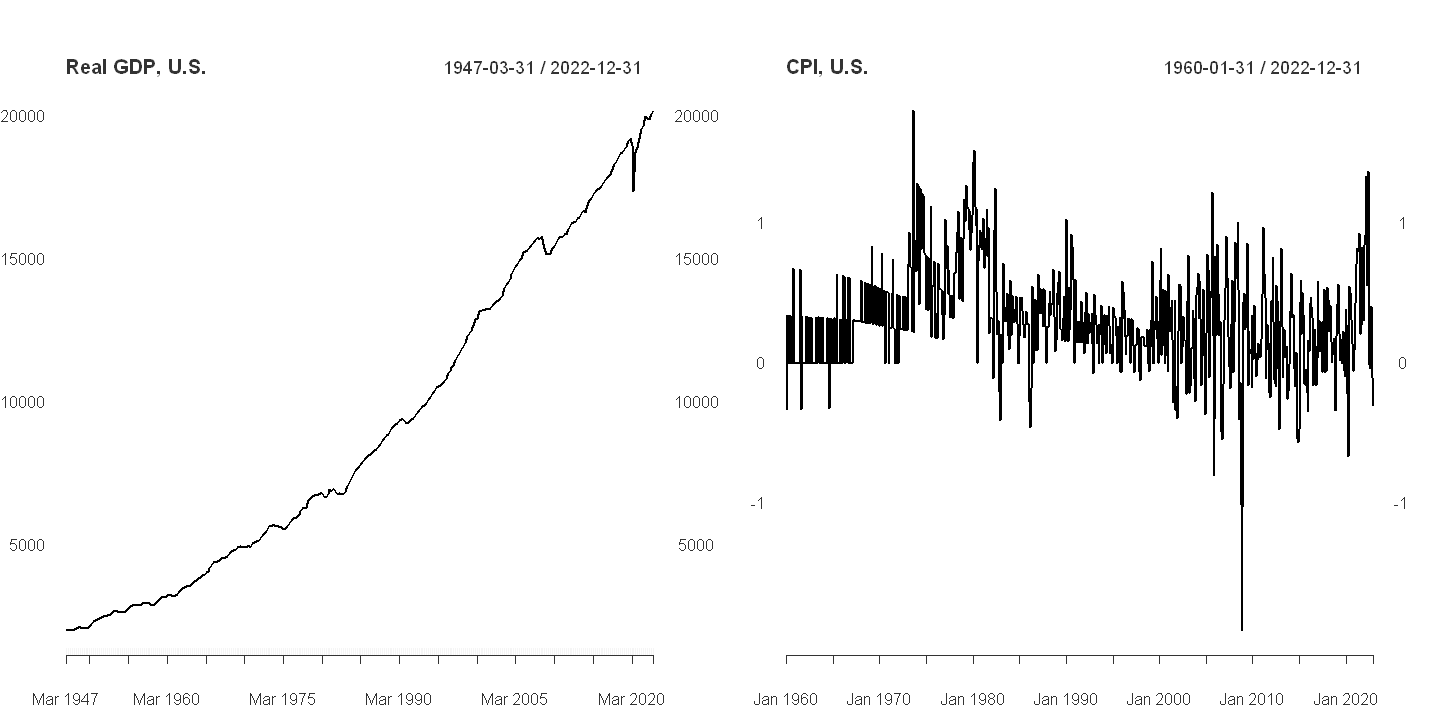

In [154]:
# Set the static variables
us_gdp_id <- "GDPC1"
us_cpi_id <- "CPALTT01USM657N"
start_date <- 2020
end_date <- 2023

# Retrieve the U.S. GDP and consumer price index data using "pdfetch_FRED"
us_gdp_data <- pdfetch_FRED(us_gdp_id)
us_cpi_data <- pdfetch_FRED(us_cpi_id)

# Plot the original time series using 'plot.xts'
par(mfrow=c(1,2))
plot.xts(us_gdp_data, main="Real GDP, U.S.", grid.col=NA, yaxis.left=TRUE)
plot.xts(us_cpi_data, main="CPI, U.S.", grid.col=NA, yaxis.left=TRUE)


### *Data transformation*:

We transform the data according to the instructions. Most comments are provided inside the code block, but we would just like to mention, that the `seas` function did not work for us, thus we decided to go with the `decompose` function for seasonal trend extraction instead.

Also, the CPI data comes in the form of percentual changes as is, so there is no need to transform it, as it had already been done for us by the data provider.

In [155]:
### 1.
# Transform GDP into log
gdp_log <- log(us_gdp_data)
colnames(gdp_log) <- "GDP"


### 2.
# Adjust seasonality using ts_first_of_period, ts_ts, and decompose functions
cpi_ts <- ts_first_of_period(us_cpi_data)
cpi_ts <- ts_ts(cpi_ts)
cpi_seasonal <- decompose(cpi_ts) # $x, $seasonal, $trend, $random

# Extract the seasonal componenets
cpi_adjusted <- cpi_seasonal$x # Seasonally adjusted price index
cpi_seasonal_fluctuations <- cpi_seasonal$seasonal # Seasonal fluctuations

After extracting the seasonal components from the CPI, we can take a look at the Y-O-Y, M-O-M, and P-O-P changes. With CPI, there arise several missing and infinite values when computing the percentage change, so we simply remove these, for simplicity. Otherwise, we make good use of the `ROC` function, which allows us to directly compute the percentage changes.

In [156]:
### 3. 
# Transform the cpi series back into xts for easier handling
cpi_dates <- index(us_cpi_data) # Use original dates
cpi_monthly <- xts(cpi_adjusted, order.by = cpi_dates)
colnames(cpi_monthly) <- "CPI"

## Period-over-period percentage changes
gdp_pop_change <- ROC(gdp_log, type='continuous') * 100
cpi_pop_change <- ROC(cpi_monthly, type='continuous') * 100
cpi_pop_change <- na.omit(cpi_pop_change[is.finite(cpi_pop_change),]) # Drop NA, Inf

## Year-over-year percentage changes
# Convert xts object to yearly frequency
gdp_yearly <- to.yearly(gdp_log)$gdp_log.Close
cpi_yearly <- to.yearly(cpi_monthly)$cpi_monthly.Close
colnames(gdp_yearly) <- "Y-O-Y GPD"
colnames(cpi_yearly) <- "Y-O-Y CPI"

# Calculate year-on-year percentage changes for GDP and CPI
gdp_yoy_change <- ROC(gdp_yearly, type='continuous') * 100
cpi_yoy_change <- ROC(cpi_yearly, type='continuous') * 100
cpi_yoy_change <- na.omit(cpi_yoy_change[is.finite(cpi_yoy_change),])

## Verify the presence of seasonal effect in the m-o-m transformed series
gdp_monthly <- to.monthly(gdp_log)$gdp_log.Close
colnames(gdp_monthly) <- "M-O-M GPD"

# Calculate month-on-month percentage changes for GDP and CPI
gdp_mom_change <- ROC(gdp_monthly, type='continuous') * 100
cpi_mom_change <- ROC(cpi_monthly, type='continuous') * 100
gdp_mom_change <- na.omit(gdp_mom_change[is.finite(gdp_mom_change),])
cpi_mom_change <- na.omit(cpi_mom_change[is.finite(cpi_mom_change),])


### *Structural validation*:

With these data, we can take a look at any potential remaining seasonal effects in the m-o-m series, check for structural breaks, stationarity, and other characteristics.

[1] "Running structural checks for monthly CPI"
[1] "Running the augmented Dickey-Fuller test for monthly CPI..."

	Augmented Dickey-Fuller Test

data:  time_series
Dickey-Fuller = -20.734, Lag order = 1, p-value = 0.01
alternative hypothesis: stationary

[1] "The m-o-m transformed series is stationary and has zero order of integration"
[1] "Running structural checks for monthly GDP"
[1] "Running the augmented Dickey-Fuller test for monthly GDP..."

	Augmented Dickey-Fuller Test

data:  time_series
Dickey-Fuller = -10.271, Lag order = 1, p-value = 0.01
alternative hypothesis: stationary

[1] "The m-o-m transformed series is stationary and has zero order of integration"


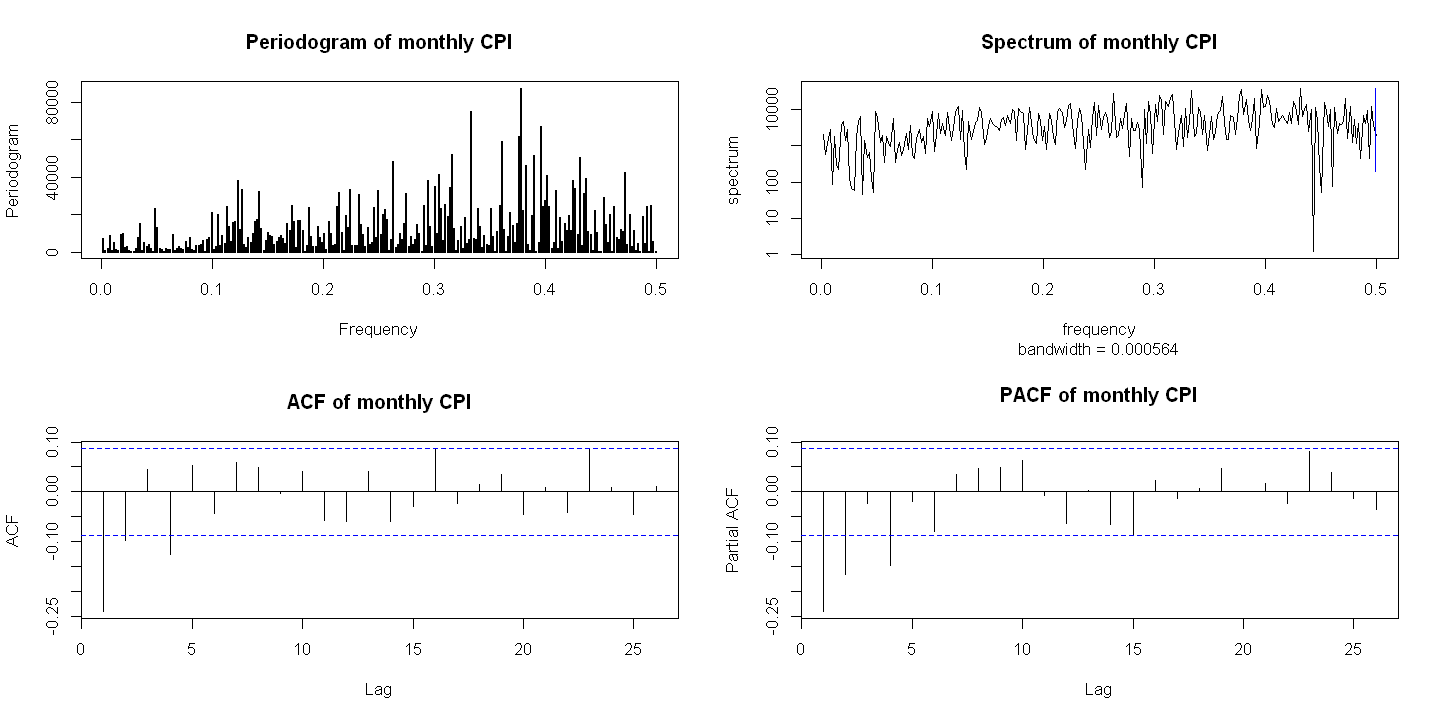

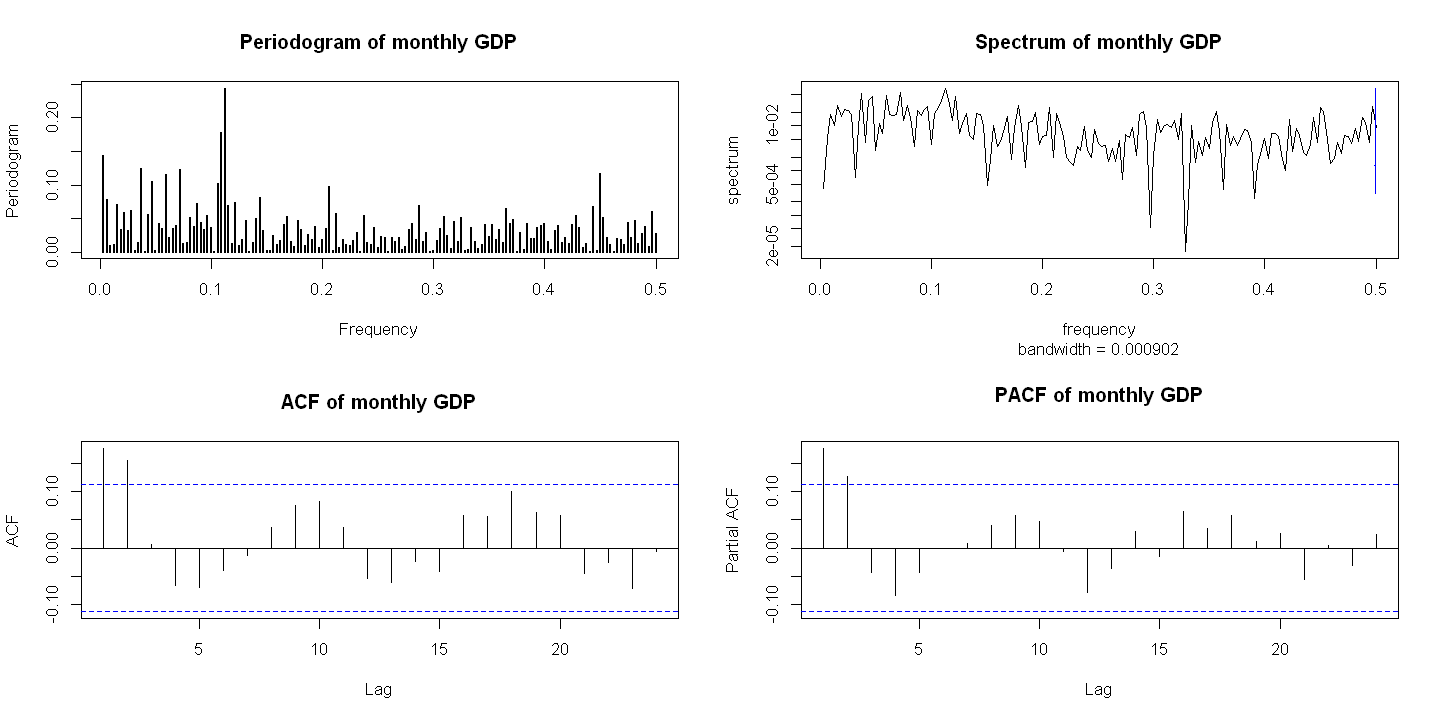

In [157]:
# Run various structural checks using a compact function (for details see the source R script)
par(mfrow=c(2,2))
runStructuralChecks(cpi_mom_change, "monthly CPI")
runStructuralChecks(gdp_mom_change, "monthly GDP")


On previous results


### *Linear Model Estimation*:

Now we will try to estimate several linear models, to see which fit the two series the best.



In [ ]:
### 4.

#
# code here

Results of the modelling section here

### *Estimating the Output Gap*:

Intro here

In [ ]:
### 5.

#Code here

Results of the output gap estimation here

##